#Objectives


This project focuses on making travel more efficient and eco-friendly by creating smart carpooling groups. The goal is to reduce both the total cost of trips and the amount of CO₂ emissions by grouping people who travel in similar directions, with an emphasis on CO2 emissions. We wanted to understand whether clustering helps or limits carpool formation. In order to evaluate this, we wanted to compare a clustering-based pipeline (KMeans, AGNES) with a greedy no-cluster strategy that only uses route, time, and driver availability. This showed us the maximum possible number of people that can be included in carpooling, and how well clustering improves cost and CO₂ optimization. A very detailed report and result comparison can be found in the submitted Report.

# Import all necessary libraries

In [ ]:
pip install gower

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta
from sklearn.cluster import AgglomerativeClustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading necessary files

In [ ]:
missions = pd.read_csv("/content/missions_fixed_1200.csv")
persons = pd.read_csv("/content/persons_fixed_1200.csv")
co2 = pd.read_csv("/content/co22.csv")

##Calculation of total CO2 and cost without any algorithm applied, from raw data

In [ ]:
import pandas as pd

# merging datasets
df = missions.merge(persons, on="person_id", how="left")

# filling missing car_model for train/plane cases, just to avoid any errors, if missing use average carpool as in greedy and evaluation/optimization functions
df["car_model"] = df["car_model"].fillna("average_carpool")

# merging with CO₂ emissions to obtain emmission values
df = df.merge(co2, on="car_model", how="left")

# plane and train CO₂
co2_plane = co2[co2["car_model"] == "plane"]["co2_per_km"].values[0]
co2_train = co2[co2["car_model"] == "TER"]["co2_per_km"].values[0]

# assigning correct CO₂ per km based on travel_type
def assign_co2(row):
    if row["travel_type"] == "plane":
        return co2_plane
    elif row["travel_type"] == "train":
        return co2_train
    else:  # default to value from car_model merge
        return row["co2_per_km"]

df["co2_corrected_per_km"] = df.apply(assign_co2, axis=1)

# calculate emissions
df["co2_emission_kg"] = df["km"].fillna(0) * df["co2_corrected_per_km"].fillna(0)

# total cost preprocessing
df["total_cost"] = df["total_cost"].fillna(0)

# summing up
total_co2 = df["co2_emission_kg"].sum()
total_cost = df["total_cost"].sum()

print(f"Total CO₂ emissions: {total_co2:.2f} kg")
print(f"Total travel cost: €{total_cost:.2f}")



Total CO₂ emissions: 50527.27 kg
Total travel cost: €443120.00


# Initial carpooling fuction (still suboptimal, no train fallback logic)

In [ ]:
def evaluate_clustered_carpooling(csv_path, co2_path="/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", cluster_col="cluster_kmeans"):

    df = pd.read_csv(csv_path)
    co2_df = pd.read_csv(co2_path)

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]
    df["has_car"] = df["has_car"].fillna(False)
    df["car_capacity"] = df["car_capacity"].fillna(0)

    carbon_tax_rate = 0.0446  # €/kg CO₂
    co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]
    carpool_groups = []
    used_person_ids = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
            route_df = route_df.sort_values("start_date")

            # Only eligible drivers
            drivers_df = route_df[
                (route_df["has_car"] == True) &
                (route_df["car_capacity"] > 0) &
                (~route_df["person_id"].isin(used_person_ids))
            ]

            for _, driver in drivers_df.iterrows():
                if driver["person_id"] in used_person_ids:
                    continue

                capacity = int(driver["car_capacity"])
                if capacity < 1:
                    continue

                passengers_df = route_df[
                    (~route_df["person_id"].isin(used_person_ids)) &
                    (route_df["person_id"] != driver["person_id"]) &
                    (route_df["has_car"] == False) &
                    (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (route_df["start_city"] == driver["start_city"]) &
                    (route_df["end_city"] == driver["end_city"])
                ]

                selected_passengers = passengers_df.head(capacity)

                #forming group (solo driver or driver + passengers)
                group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])
                group_df["carpool_group_id"] = f"group_{group_id}"
                group_df["cluster"] = cluster
                group_df["travel_mode"] = "carpool"

                used_person_ids.add(driver["person_id"])
                used_person_ids.update(selected_passengers["person_id"].values)
                carpool_groups.append(group_df)
                group_id += 1

    # handling unassigned people (solo fallback logic)
    unassigned = df[~df["person_id"].isin(used_person_ids)].copy()
    for _, row in unassigned.iterrows():
        row = row.copy()
        row["carpool_group_id"] = f"group_{group_id}"
        row["cluster"] = row[cluster_col]

        if row["has_car"]:
            row["travel_mode"] = "car (solo)"
            co2_used = row["co2_per_km"]
        else:
            row["travel_mode"] = "train (solo)"
            co2_used = co2_train
            print(f"\n[Info] {row['first_name']} {row['last_name']} (ID: {row['person_id']}) assigned to solo train travel.")

        row["co2_emission_kg"] = co2_used * row["km"]
        carpool_groups.append(pd.DataFrame([row]))
        used_person_ids.add(row["person_id"])
        group_id += 1

    # Final results
    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])

        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        for group_id, group in carpool_df.groupby("carpool_group_id"):
            # Display group info
            driver_row = group[group["has_car"] == True]
            if driver_row.empty:
                solo = group.iloc[0]
                print(f"\nGroup {solo['carpool_group_id']} | Cluster: {solo['cluster']}")
                print(f"Route: {solo['start_city']} ➝ {solo['end_city']}")
                print(f"Start Dates: {solo['start_date'].date()} – {solo['end_date'].date()}")
                print(f"Solo Travel: {solo['travel_mode']}")
                print(f"Traveler: {solo['first_name']} {solo['last_name']} (ID: {solo['person_id']})")
            else:
                driver = driver_row.iloc[0]
                passengers = group[group["has_car"] == False]

                print(f"\nGroup {group_id} | Cluster: {group['cluster'].iloc[0]}")
                print(f"Route: {driver['start_city']} ➝ {driver['end_city']}")
                print(f"Start Dates: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
                print(f"Driver: {driver['first_name']} {driver['last_name']} (ID: {driver['person_id']})")
                if not passengers.empty:
                    print("Passengers:")
                    for _, p in passengers.iterrows():
                        print(f"  - {p['first_name']} {p['last_name']} (ID: {p['person_id']})")
                else:
                    print("(No passengers – solo driver)")

            # HOTEL COSTS per person based on group event range
            event_start = group["start_date"].min().normalize()
            event_end = group["end_date"].max().normalize()

            for i, person in group.iterrows():
                person_start = person["start_date"].normalize()
                person_end = person["end_date"].normalize()

                early_nights = (event_start - person_start).days
                late_nights = (person_end - event_end).days

                early_nights = min(max(early_nights, 0), 2)
                late_nights = max(late_nights, 0)

                extra_night_cost = (early_nights + late_nights) * person["hotel_cost"]

                total_person_cost = person["hotel_cost"] + extra_night_cost + person["parking_cost"]
                carpool_df.loc[i, "computed_total_cost"] = total_person_cost

                if extra_night_cost > 0:
                    print(f"  [Hotel Cost] {person['first_name']} {person['last_name']} "
                          f"(ID: {person['person_id']}) → +€{extra_night_cost} (extra nights)")


        # compute and display total summary
        total_cost = carpool_df["computed_total_cost"].sum()

        print(f"\nCluster-based Carpool Evaluation — Source: {csv_path}")
        print(f"Total groups formed: {carpool_df['carpool_group_id'].nunique()}")
        print(f"Total people assigned: {carpool_df['person_id'].nunique()}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO₂ emission: {round(total_co2, 2)} kg")
        print(f"CO₂ tax: €{round(co2_tax, 2)}")

    else:
        print("\nNo valid carpool groups formed.")


# Final optimized carpooling function

In [ ]:
def evaluate_optimized_carpooling(csv_path, co2_path, cluster_col="cluster_kmeans"):

    df = pd.read_csv(csv_path)
    co2_df = pd.read_csv(co2_path)

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    df["has_car"] = df["has_car"].fillna(False)
    df["car_capacity"] = df["car_capacity"].fillna(0)
    df["car_model"] = df["car_model"].fillna("average_carpool")
    df["travel_type"] = df["travel_type"].fillna("unknown")

    df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")
    co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

    carbon_tax_rate = 0.0446  # €/kg CO₂
    carpool_groups = []
    used_person_ids = set()
    group_id = 1

    train_durations = {
        ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
        ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
        ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
        ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
        ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
        ("Besançon", "Strasbourg"): 1.5
    }
    car_durations = {
        ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
        ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
        ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
        ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
        ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
        ("Besançon", "Strasbourg"): 2.5
    }

    # Group people into carpools
    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
            route_df = route_df.sort_values("start_date")

            drivers_df = route_df[
                (route_df["has_car"] == True) &
                (route_df["car_capacity"] > 0) &
                (~route_df["person_id"].isin(used_person_ids))
            ]

            for _, driver in drivers_df.iterrows():
                if driver["person_id"] in used_person_ids:
                    continue

                capacity = int(driver["car_capacity"])
                if capacity < 1:
                    continue

                passengers_df = route_df[
                    (~route_df["person_id"].isin(used_person_ids)) &
                    (route_df["person_id"] != driver["person_id"]) &
                    (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (route_df["start_city"] == driver["start_city"]) &
                    (route_df["end_city"] == driver["end_city"])
                ]

                selected_passengers = passengers_df.head(capacity)
                group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])
                group_df["carpool_group_id"] = f"group_{group_id}"
                group_df["cluster"] = cluster
                group_df["travel_mode_optimized"] = "car"

                #train optimization
                if (start_city, end_city) in train_durations and (start_city, end_city) in car_durations:
                    if car_durations[(start_city, end_city)] - train_durations[(start_city, end_city)] >= 2:
                        group_df["travel_mode_optimized"] = "train"

                carpool_groups.append(group_df)
                used_person_ids.update(group_df["person_id"].values)
                group_id += 1

    # Assign unassigned people to optimized solo travel
    unassigned = df[~df["person_id"].isin(used_person_ids)].copy()
    for _, row in unassigned.iterrows():
        row = row.copy()
        row["carpool_group_id"] = f"group_{group_id}"
        row["cluster"] = row[cluster_col]

        route_key = (row["start_city"], row["end_city"])
        can_take_train = (
            route_key in train_durations and route_key in car_durations and
            (car_durations[route_key] - train_durations[route_key] >= 2)
        )

        if not row["has_car"] or can_take_train:
            row["travel_mode_optimized"] = "train"
            row["co2_per_km_used"] = co2_train
            print(f"[Info] {row['first_name']} {row['last_name']} assigned to solo train travel.")
        else:
            row["travel_mode_optimized"] = "car"
            row["co2_per_km_used"] = row["co2_per_km"]
            print(f"[Info] {row['first_name']} {row['last_name']} assigned to solo car travel.")

        row["co2_emission_kg"] = row["co2_per_km_used"] * row["km"]
        carpool_groups.append(pd.DataFrame([row]))
        used_person_ids.add(row["person_id"])
        group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])

        carpool_df["co2_per_km_used"] = carpool_df.apply(
            lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"], axis=1
        )
        carpool_df["co2_emission_kg"] = carpool_df["co2_per_km_used"] * carpool_df["km"]

        # HOTEL COSTS
        for group_id, group in carpool_df.groupby("carpool_group_id"):
            event_start = group["start_date"].min().normalize()
            event_end = group["end_date"].max().normalize()

            for i, person in group.iterrows():
                person_start = person["start_date"].normalize()
                person_end = person["end_date"].normalize()

                early_nights = min(max((event_start - person_start).days, 0), 2)
                late_nights = max((person_end - event_end).days, 0)

                extra_night_cost = (early_nights + late_nights) * person["hotel_cost"]

                total_person_cost = person["hotel_cost"] + extra_night_cost + person["parking_cost"]
                carpool_df.loc[i, "computed_total_cost"] = total_person_cost

                if extra_night_cost > 0:
                    print(f"  [Hotel Cost] {person['first_name']} {person['last_name']} "
                          f"(ID: {person['person_id']}) → +€{extra_night_cost} (extra nights)")


        # compute and display total summary
        total_cost = carpool_df["computed_total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"\nCluster-based Carpool Evaluation — Source: {csv_path}")
        print(f"Total groups formed: {carpool_df['carpool_group_id'].nunique()}")
        print(f"Total people assigned: {carpool_df['person_id'].nunique()}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO₂ emission: {round(total_co2, 2)} kg")
        print(f"CO₂ tax: €{round(co2_tax, 2)}")

        # Print group summaries
   #     for group_id, group in carpool_df.groupby("carpool_group_id"):
   #         print(f"\nGroup {group_id} | Cluster: {group['cluster'].iloc[0]}")
   #         print(f"Route: {group['start_city'].iloc[0]} ➝ {group['end_city'].iloc[0]}")
   #         print(f"Start Dates: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
   #         print(f"Travel Mode: {group['travel_mode_optimized'].iloc[0]}")

  #        driver_row = group[group["has_car"] == True]
   #         driver_info = "(Train Group or No Driver)"
    #        if not driver_row.empty:
     #           driver = driver_row.iloc[0]
    #            driver_info = f"{driver['first_name']} {driver['last_name']} (ID: {driver['person_id']})"
    #        print(f"Driver: {driver_info}")

     #       passengers = group[group["has_car"] == False]
      #      if not passengers.empty:
       #         print("Passengers:")
        #        for _, p in passengers.iterrows():
         #           print(f"  - {p['first_name']} {p['last_name']} (ID: {p['person_id']})")
         #   else:
          #      print("(No passengers – solo driver or train traveler)")

    else:
        print("\nNo valid carpool groups formed.")


# Greedy algorithm

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df.drop_duplicates(subset=["mission_id"])

#preprocessing
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], errors="coerce")
df["car_model"] = df["car_model"].fillna("average_carpool")
df["has_car"] = df["has_car"].fillna(False)
df["car_capacity"] = df["car_capacity"].fillna(0)
df["is_return_trip"] = df["is_return_trip"].fillna(0).astype(int)
df.dropna(subset=["start_city", "end_city", "start_date", "end_date"], inplace=True)

#checking total number of drivers
drivers_df = df[(df["has_car"] == True) & (df["car_capacity"] > 0)].copy()
print(f"\nTotal drivers available: {len(drivers_df)}")

drivers_df.sort_values("start_date", inplace=True)
df.sort_values("start_date", inplace=True)

#creating carpool groups
carpool_groups = []
used_ids = set()
group_id = 1

for _, driver in drivers_df.iterrows():
    if driver["person_id"] in used_ids:
        continue

    capacity = int(driver["car_capacity"])
    if capacity < 1:
        continue

    potential_passengers = df[
        (~df["person_id"].isin(used_ids)) &
        (df["person_id"] != driver["person_id"]) &
        (df["has_car"] == False) &
        (df["start_city"] == driver["start_city"]) &
        (df["end_city"] == driver["end_city"]) &
        (df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
        (df["start_date"] <= driver["start_date"] + timedelta(days=2))
    ].copy()

    selected_passengers = potential_passengers.head(capacity)

    if selected_passengers.empty:
        #allowing solo driver group
        group_df = pd.DataFrame([driver])
    else:
        group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])

    group_df["carpool_group_id"] = f"group_{group_id}"
    group_df["transport_mode"] = "car"
    carpool_groups.append(group_df)

    used_ids.add(driver["person_id"])
    used_ids.update(selected_passengers["person_id"].values)
    group_id += 1

final = pd.concat(carpool_groups) if carpool_groups else pd.DataFrame()

assigned_ids = set(final["person_id"].values) if not final.empty else set()
unassigned_df = df[~df["person_id"].isin(assigned_ids)].copy()
non_drivers = unassigned_df[unassigned_df["has_car"] == False].copy()
non_drivers.sort_values("start_date", inplace=True)


train_groups = []
used_train = set()
train_group_id = 1

for idx, person in non_drivers.iterrows():
    if person["person_id"] in used_train:
        continue

    matches = non_drivers[
        (~non_drivers["person_id"].isin(used_train)) &
        (non_drivers["person_id"] != person["person_id"]) &
        (non_drivers["start_city"] == person["start_city"]) &
        (non_drivers["end_city"] == person["end_city"]) &
        (non_drivers["start_date"] >= person["start_date"] - timedelta(days=2)) &
        (non_drivers["start_date"] <= person["start_date"] + timedelta(days=2))
    ]

    group_df = pd.concat([pd.DataFrame([person]), matches])
    group_df["carpool_group_id"] = f"train_group_{train_group_id}"
    group_df["transport_mode"] = "train"
    train_groups.append(group_df)

    used_train.update(group_df["person_id"].values)
    train_group_id += 1


#adding train groups to final
if train_groups:
    train_final = pd.concat(train_groups)
    train_final["has_car"] = False
    final = pd.concat([final, train_final], ignore_index=True)

#postprocessing and summary
if not final.empty:
    final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
    final["days"] = final["days"].clip(lower=1)
    final["co2_total"] = final["co2_per_km"] * final["km"]
    final["hotel_total"] = final["hotel_cost"] * final["days"]
    final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

    stats = final.groupby("carpool_group_id").agg({
        "co2_total": "sum",
        "total_trip_cost": "sum",
        "person_id": "count",
        "transport_mode": "first"
    }).rename(columns={"person_id": "number_of_people"})

    print(stats.head(10))
    print(f"\nTotal groups formed: {len(stats)}")
    print(f"Total people assigned: {final['person_id'].nunique()}")
    print(f"Total CO₂: {stats['co2_total'].sum():.2f} kg")
    print(f"Total cost: {stats['total_trip_cost'].sum():.2f} €")

    print("\nGroup types:")
    print(stats["transport_mode"].value_counts())

    #displaying group details
    #for group_id, group in final.groupby("carpool_group_id"):
     #   mode = group["transport_mode"].iloc[0]
      #  print(f"\nGroup {group_id} | Mode: {mode}")
       # print(f"Route: {group['start_city'].iloc[0]} ➝ {group['end_city'].iloc[0]}")
        #print(f"Date range: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
        #for _, p in group.iterrows():
         #   print(f"  - {p['person_id']} | {p['first_name']} {p['last_name']}")

else:
    print("No groups could be formed.")



Total drivers available: 842
                  co2_total  total_trip_cost  number_of_people transport_mode
carpool_group_id                                                             
group_1             116.920             1018                 1            car
group_10             76.960              416                 1            car
group_100            97.240              944                 1            car
group_101           113.220             1745                 1            car
group_102            21.690             1515                 1            car
group_103            15.210              480                 1            car
group_104            35.335             1834                 1            car
group_105             8.670             1672                 1            car
group_106           125.630             1446                 1            car
group_107            84.320              463                 1            car

Total groups formed: 1112
Total p

# Experiment 1 - 4 features (km, total_cost, co2_per_km, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()

In [ ]:
df_selected.fillna(df_selected.mean(), inplace=True)

#OneHotEncode for 'is return trip' because it is categorical variable
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]), columns=encoder.get_feature_names_out(["is_return_trip"]))

#combining 'is return trip' column with the numerical features
df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1), encoded_df], axis=1)

#scaling the data
scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])

We applied KMeans and AGNES clustering on a Gower distance matrix using the most relevant carpooling-related features:

- km (travel distance),
- total_cost (trip cost),
- co2_per_km (CO₂ efficiency),
- is_return_trip (boolean).

To handle the mixed data types, we encoded the categorical variable (is_return_trip) using OneHotEncoder and applied StandardScaler to numerical features. The clustering was performed with KMeans (k=10) and evaluated using the Silhouette Score. Silhouette score indicates that clusters are somewhat separated, but not perfectly distinct.

We visualized the clusters using PCA to reduce the high-dimensional data to 2D. The PCA plot shows that:
- two dominant groups are clearly separated across PCA Component 1.
- some smaller clusters overlap, likely due to similar costs or emissions profiles.

## k=10

Silhouette Score: 0.277


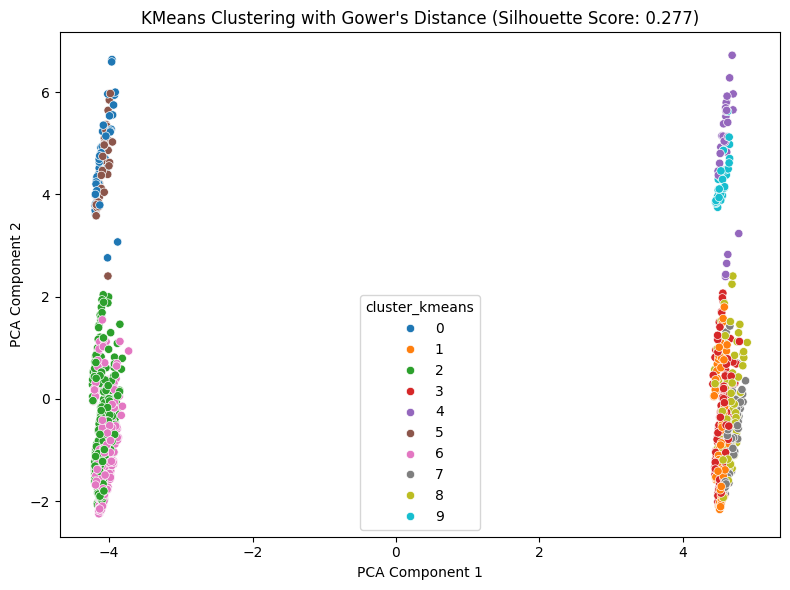

In [ ]:
#calculate Gower's Distance since it gives good results when it comes to mixed datasets, such as this one
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
2    288
6    260
3    148
1    129
8    123
7     98
0     48
5     40
9     36
4     30
Name: count, dtype: int64


The KMeans clustering algorithm formed 10 distinct clusters. Cluster sizes range from 9 to 42 individuals. Most clusters are evenly populated, which indicates a well-balanced partitioning of the dataset. Smaller clusters may represent unique travel patterns or outliers.

So a cluster doesn't mean one carpool group , instead it's more like a pool of candidates who are traveling similarly (maybe on similar routes, durations, emissions) and can be considered for potential grouping together, which will be optimized in later steps.

## k=30

Silhouette Score: 0.242


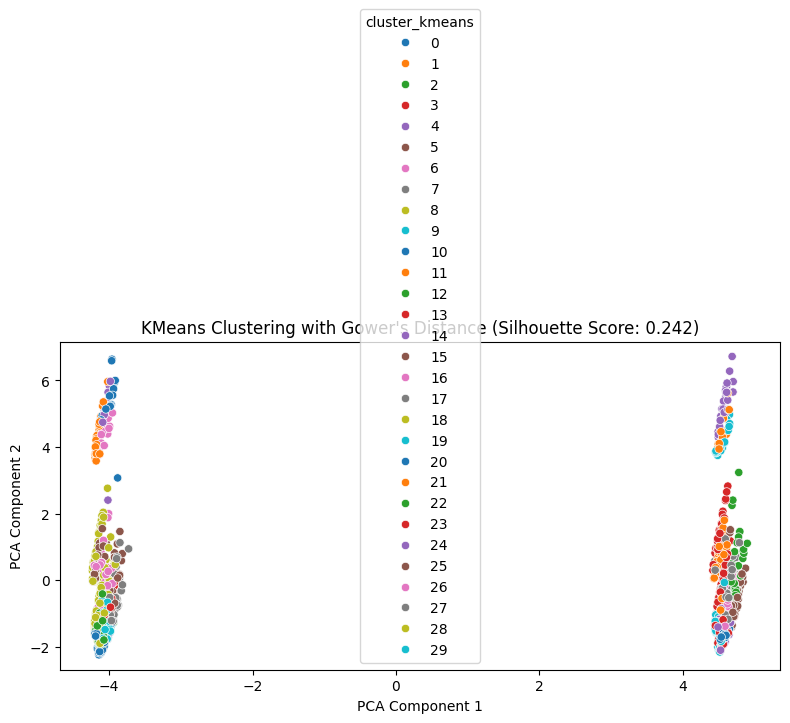

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
#saving the results
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv", index=False)

In [ ]:
#printing out the results
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
18    69
9     65
19    62
3     57
13    55
16    52
14    52
20    50
28    48
15    45
12    44
2     44
17    44
1     40
23    39
27    39
5     38
10    37
22    36
26    36
8     34
21    33
7     33
25    33
4     26
24    20
0     18
29    18
11    17
6     16
Name: count, dtype: int64


Now, we applied KMeans clustering with k=30 on the dataset using the most relevant carpooling features as earlier .
The clustering was based on a Gower distance matrix that handles both numerical and categorical data. The result produced 30 distinct clusters, with sizes ranging from 4 to 20 individuals.

Most clusters are reasonably sized , which is ideal for forming smaller carpooling groups. Some clusters are very small, possibly capturing unique patterns (outliers or highly specific emission-cost profiles).

This granularity could help us match more compatible carpooling candidates and reduce CO₂ emissions more precisely during optimization.

We will do in the next step clustering with k=50 and then we will create groups based on these three types with k=10, k=30 and k=50 to see which gives the best result.

## k=50

Silhouette Score: 0.274


<ipython-input-232-4001955589>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


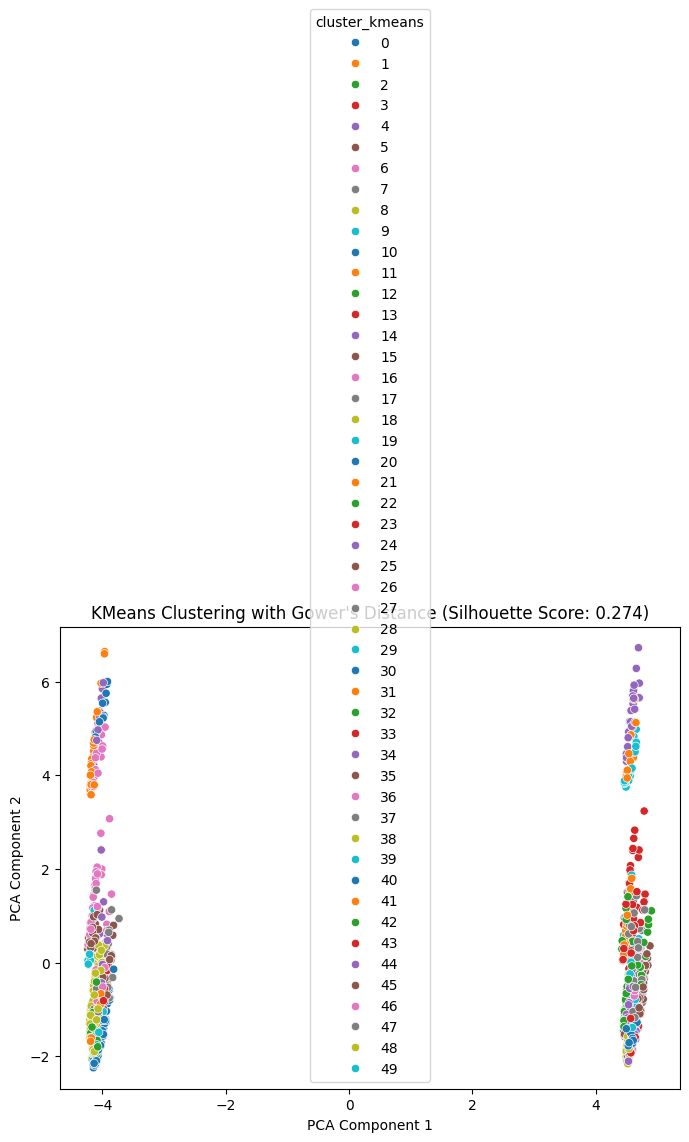

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_kmeans
8     39
14    37
18    37
31    36
27    35
2     35
9     34
20    33
48    32
3     32
28    31
5     31
35    31
49    31
12    30
17    29
10    27
47    27
15    26
4     26
30    25
23    25
32    23
38    23
19    23
37    23
13    23
34    22
44    21
40    21
21    21
22    20
46    20
25    20
45    19
24    19
29    18
36    18
7     18
11    17
26    17
0     17
1     16
6     16
42    15
16    14
41    13
33    13
39    13
43     8
Name: count, dtype: int64


In the end of clustering with Kmeans, we performed KMeans clustering with k=50 using the four core features relevant to carpooling based on a Gower distance matrix.

The result produced 50 clusters, with sizes ranging from 1 to 13 individuals:
- Most clusters are small, between 3-7 members.
- A few clusters have 10 or more members, which are more promising for forming carpool groups.
- However, over 10 clusters have only 1-2 members, which indicates possible over-segmentation or noise.

This clustering may offer very fine-grained grouping, but the large number of tiny clusters might limit practical carpool formation. We'll compare it with other `k` values in the optimization phase to evaluate trade-offs between precision and usability.


## Grouping and comparing various types of k

In [ ]:
#k=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
Driver: Inès Bouvet (ID: 1006)
(No passengers – solo driver)

Group group_251 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2020-08-08 – 2020-08-08
Driver: Paulette Marion (ID: 868)
(No passengers – solo driver)

Group group_252 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2021-01-03 – 2021-01-03
Driver: Océane Pasquier (ID: 153)
(No passengers – solo driver)

Group group_253 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2022-11-01 – 2022-11-01
Driver: Grégoire Pelletier (ID: 658)
(No passengers – solo driver)

Group group_254 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2023-05-23 – 2023-05-23
Driver: Arthur Pruvost (ID: 1020)
(No passengers – solo driver)

Group group_255 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2024-07-04 – 2024-07-04
Driver: Nicole Delannoy (ID: 285)
(No passengers – solo driver)

Group group_256 | Cluster: 2
Route: Montbéliard ➝ Paris
Start Dates: 2025-02-19 – 2025-02-19
D

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
Route: Besançon ➝ Nice
Start Dates: 2022-11-25 – 2022-11-25
Driver: Xavier Dupré (ID: 600)
(No passengers – solo driver)

Group group_250 | Cluster: 5
Route: Besançon ➝ Dijon
Start Dates: 2022-09-19 – 2022-09-19
Driver: Michel Richard (ID: 169)
(No passengers – solo driver)

Group group_251 | Cluster: 5
Route: Besançon ➝ Lyon
Start Dates: 2022-07-23 – 2022-07-23
Driver: Yves Pierre (ID: 906)
(No passengers – solo driver)

Group group_252 | Cluster: 5
Route: Besançon ➝ Lyon
Start Dates: 2022-09-09 – 2022-09-09
Driver: Océane Mace (ID: 657)
(No passengers – solo driver)

Group group_253 | Cluster: 5
Route: Besançon ➝ Lyon
Start Dates: 2022-12-23 – 2022-12-23
Driver: Alexandre Guillot (ID: 925)
(No passengers – solo driver)

Group group_254 | Cluster: 5
Route: Besançon ➝ Marseille
Start Dates: 2022-07-13 – 2022-07-13
Driver: Brigitte Clément (ID: 1114)
(No passengers – solo driver)

Group group_255 | Cluster: 5
Route: Besançon ➝ Nice
Star

In [ ]:
#k=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 3
Route: Montbéliard ➝ Lyon
Start Dates: 2021-04-16 – 2021-04-16
Driver: Thérèse Rémy (ID: 782)
(No passengers – solo driver)

Group group_250 | Cluster: 12
Route: Belfort ➝ Paris
Start Dates: 2022-09-03 – 2022-09-03
Driver: Frédéric Thomas (ID: 218)
(No passengers – solo driver)

Group group_251 | Cluster: 12
Route: Belfort ➝ Strasbourg
Start Dates: 2024-12-26 – 2024-12-26
Driver: André Barbier (ID: 168)
(No passengers – solo driver)

Group group_252 | Cluster: 12
Route: Belfort ➝ Strasbourg
Start Dates: 2025-01-29 – 2025-01-29
Driver: Françoise Roux (ID: 668)
(No passengers – solo driver)

Group group_253 | Cluster: 12
Route: Belfort ➝ Toulouse
Start Dates: 2020-09-01 – 2020-09-01
Driver: Gilles Peron (ID: 1133)
(No passengers – solo driver)

Group group_254 | Cluster: 12
Route: Belfort ➝ Toulouse
Start Dates: 2022-12-04 – 2022-12-04
Driver: Anouk François (ID: 479)
(No passeng

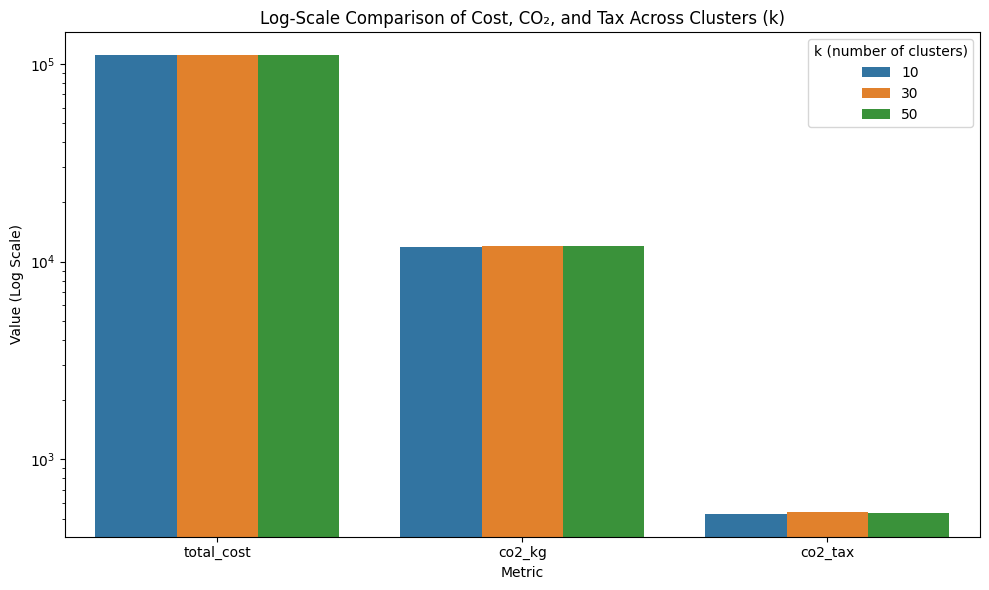

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [11909.28, 11983.22, 12021.06],
    "co2_tax": [531.15, 543.45, 536.14]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

This bar chart uses a logarithmic scale to visually compare the impact of different KMeans cluster sizes on three key metrics:

- **Total Cost (€)**
- **Total CO₂ Emissions (kg)**
- **CO₂ Tax (€)**

Using a log scale helps to see relative differences between the values, even when some are an order of magnitude larger than others. It clearly shows that as the number of clusters increases, both **cost** and **CO₂ emissions** decrease significantly, making higher-k solutions more eco- and budget-friendly.

If we cluster smarter (k=10), we spend less and pollute less.

## Optimization of algorithm based on results of k=10 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

## Optimization of algorithm based on results of k=30 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

## Optimization of algorithm based on results of k=50 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

##Comparison of optimized results

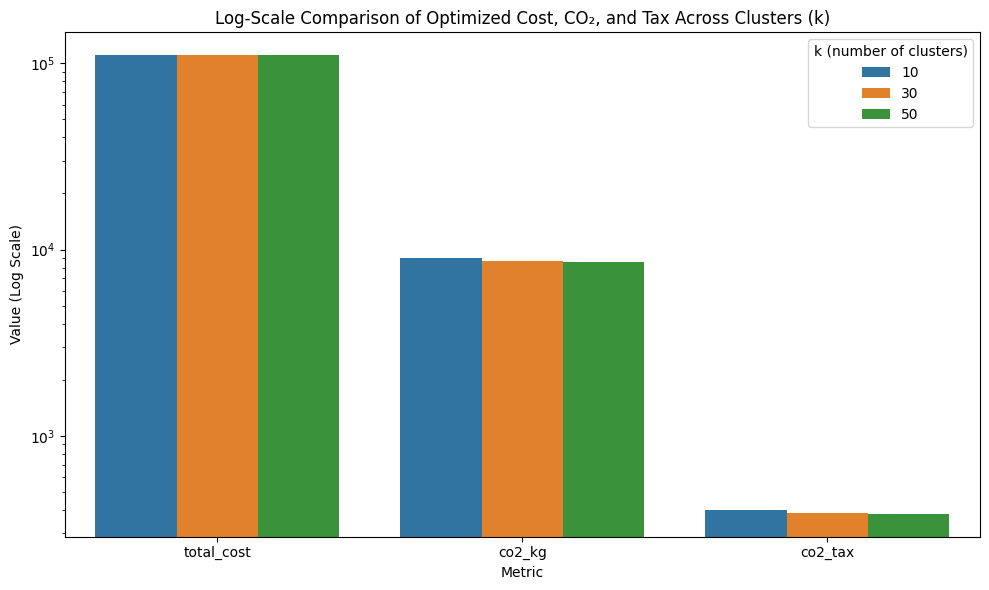

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [8951.28, 8653.8, 8563.72],
    "co2_tax": [399.23, 385.96, 381.94]
})


df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Optimized Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

## agnes n=10

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.396


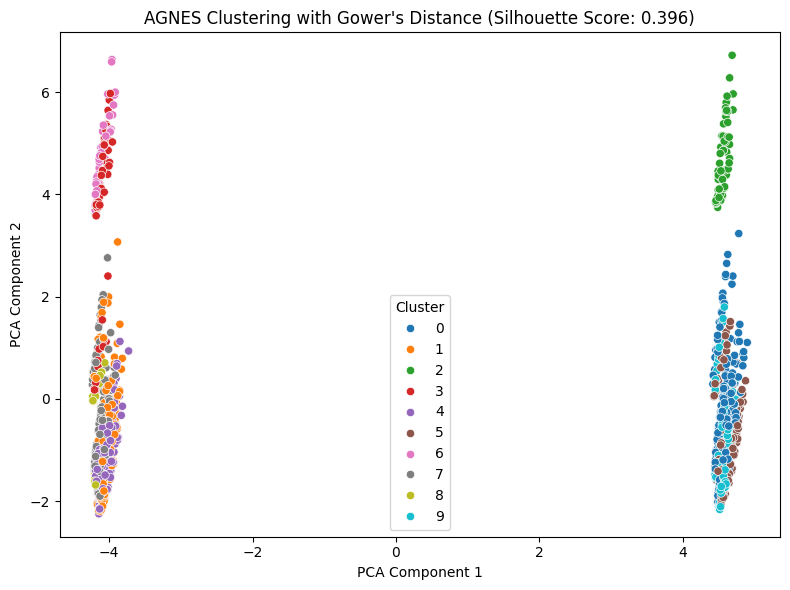

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
0    230
4    204
1    157
9    146
7    142
5    127
3     64
2     61
6     41
8     28
Name: count, dtype: int64


## agnes n=30

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.393


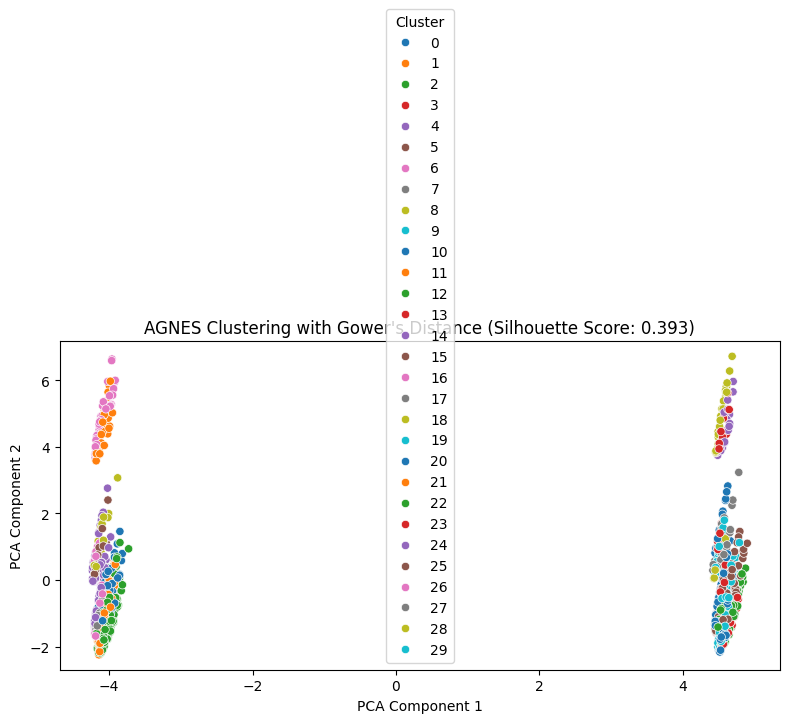

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
2     103
5      94
0      77
21     74
22     70
9      66
12     62
20     61
11     57
4      53
10     44
7      44
1      44
6      41
3      36
19     34
29     28
8      24
25     23
24     22
15     20
18     18
14     16
16     15
23     15
13     13
17     13
26     12
27     11
28     10
Name: count, dtype: int64


## agnes n=50

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.440


<ipython-input-249-2529285127>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


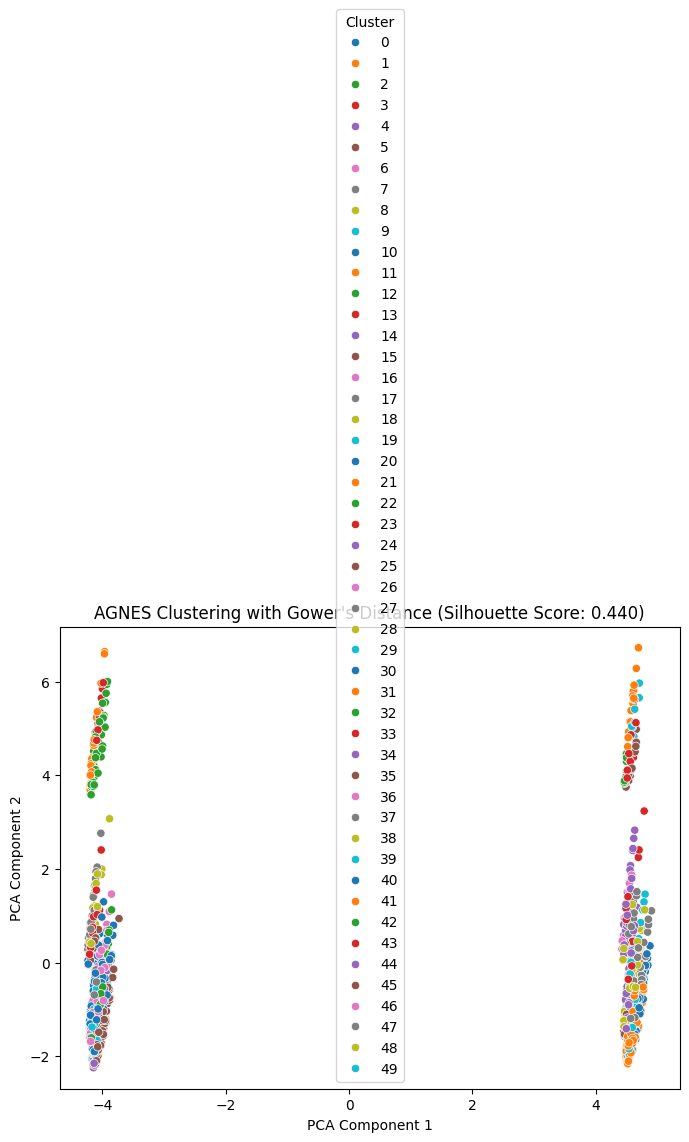

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=50, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 50
Cluster sizes:
 cluster_agnes
0     74
1     61
15    60
17    49
2     43
10    40
20    40
6     40
8     38
30    37
14    34
9     31
5     31
46    31
44    30
19    30
41    28
29    28
39    28
4     26
31    24
25    23
11    22
3     20
33    19
48    19
18    18
47    17
32    17
22    16
7     15
23    15
24    15
21    15
45    14
34    14
36    14
37    13
13    13
26    12
35    11
27    11
16    10
28    10
38    10
12     9
42     9
49     8
40     5
43     3
Name: count, dtype: int64


## Grouping and comparing agnes results

In [ ]:
#n=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
Start Dates: 2022-01-03 – 2022-01-03
Driver: Hélène Allain (ID: 84)
(No passengers – solo driver)

Group group_252 | Cluster: 3
Route: Belfort ➝ Nice
Start Dates: 2022-10-22 – 2022-10-22
Driver: Hortense Faure (ID: 845)
(No passengers – solo driver)

Group group_253 | Cluster: 3
Route: Belfort ➝ Nice
Start Dates: 2023-04-11 – 2023-04-11
Driver: Sylvie Chauvet (ID: 601)
(No passengers – solo driver)

Group group_254 | Cluster: 3
Route: Belfort ➝ Nice
Start Dates: 2025-01-29 – 2025-01-29
Driver: Émilie Lombard (ID: 655)
(No passengers – solo driver)

Group group_255 | Cluster: 3
Route: Belfort ➝ Paris
Start Dates: 2021-01-01 – 2021-01-01
Driver: Marie Garnier (ID: 685)
(No passengers – solo driver)

Group group_256 | Cluster: 3
Route: Belfort ➝ Paris
Start Dates: 2022-10-23 – 2022-10-23
Driver: Aurélie Antoine (ID: 888)
(No passengers – solo driver)

Group group_257 | Cluster: 3
Route: Belfort ➝ Strasbourg
Start Dates: 2023-02-11 – 2023-

In [ ]:
#n=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
Driver: William Adam (ID: 150)
(No passengers – solo driver)

Group group_250 | Cluster: 9
Route: Belfort ➝ Paris
Start Dates: 2021-02-08 – 2021-02-08
Driver: Suzanne Torres (ID: 777)
(No passengers – solo driver)

Group group_251 | Cluster: 9
Route: Belfort ➝ Paris
Start Dates: 2022-11-24 – 2022-11-24
Driver: Robert Pottier (ID: 710)
(No passengers – solo driver)

Group group_252 | Cluster: 9
Route: Belfort ➝ Paris
Start Dates: 2024-01-23 – 2024-01-23
Driver: Valérie Jacques (ID: 286)
(No passengers – solo driver)

Group group_253 | Cluster: 9
Route: Belfort ➝ Paris
Start Dates: 2024-09-20 – 2024-09-20
Driver: Édith Raynaud (ID: 662)
(No passengers – solo driver)

Group group_254 | Cluster: 9
Route: Belfort ➝ Strasbourg
Start Dates: 2025-05-22 – 2025-05-22
Driver: Élise Becker (ID: 937)
(No passengers – solo driver)

Group group_255 | Cluster: 9
Route: Belfort ➝ Toulouse
Start Dates: 2021-03-19 – 2021-03-19
Driver: Camille Dumas (ID: 

In [ ]:
#n=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 17
Route: Besançon ➝ Marseille
Start Dates: 2023-10-02 – 2023-10-02
Driver: William Adam (ID: 150)
(No passengers – solo driver)

Group group_250 | Cluster: 20
Route: Montbéliard ➝ Marseille
Start Dates: 2023-08-30 – 2023-08-30
Driver: Bertrand Picard (ID: 269)
(No passengers – solo driver)

Group group_251 | Cluster: 20
Route: Montbéliard ➝ Marseille
Start Dates: 2024-09-04 – 2024-09-04
Driver: Adrienne Leclerc (ID: 10)
(No passengers – solo driver)

Group group_252 | Cluster: 20
Route: Montbéliard ➝ Nice
Start Dates: 2021-08-22 – 2021-08-22
Driver: Augustin Gallet (ID: 851)
(No passengers – solo driver)

Group group_253 | Cluster: 20
Route: Montbéliard ➝ Nice
Start Dates: 2022-03-10 – 2022-03-10
Driver: Caroline Rey (ID: 151)
(No passengers – solo driver)

Group group_254 | Cluster: 20
Route: Montbéliard ➝ Nice
Start Dates: 2023-10-03 – 2023-10-03
Driver: Jeanne Samson (ID: 834

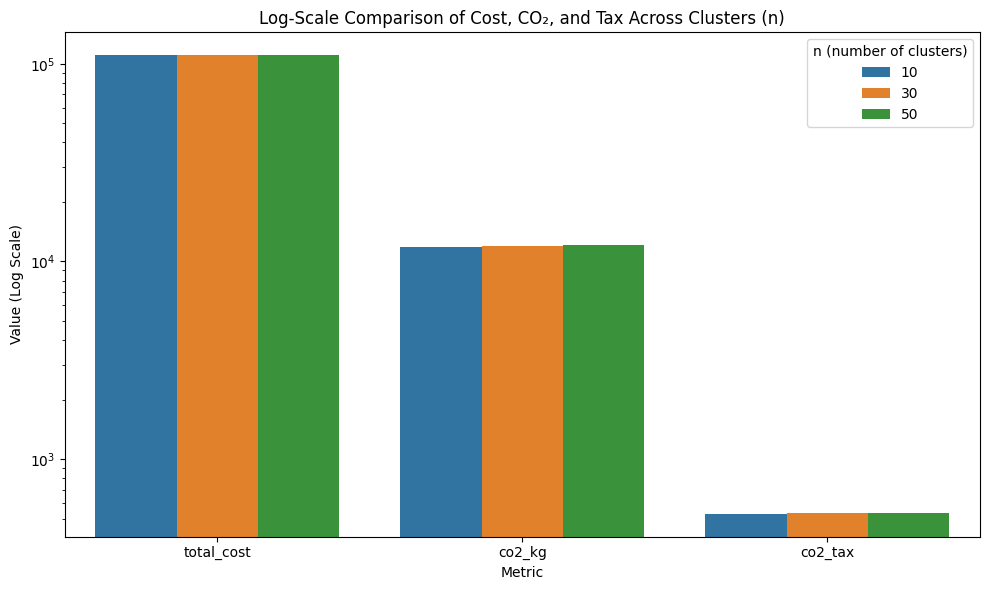

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350,110350,110350],
    "co2_kg": [11889.39, 12002.32, 12041.48],
    "co2_tax": [530.27, 535.3, 537.05]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

## Optimization of algorithm with n=10 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to solo train travel.
[Info] Émilie Paris assigned to solo 

## Optimization algorithm with n=30 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

## Optimization of algorithm with n=50 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

##Comparison of the optimized results

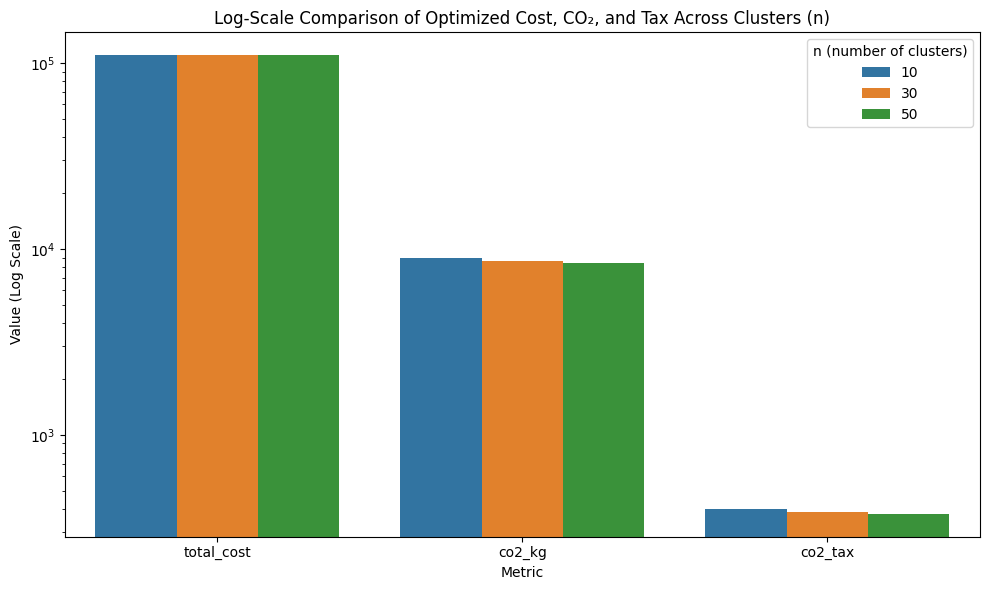

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350,110350,110350],
    "co2_kg": [8939.09, 8611.17, 8447.94],
    "co2_tax": [398.68, 384.06, 376.78]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Optimized Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

# Experiment 2 - 11 features (start_city,end_city,travel_type, vehicle_type,has_car,car_capacity,start_hour,km,total_cost,co2_per_km, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] =  df["start_date"].apply(lambda x: x.toordinal()) #ordinal numeric format, in order to be able to apply the clustering algorithms

df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]
df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


## k=10 kmeans

Silhouette Score: 0.182


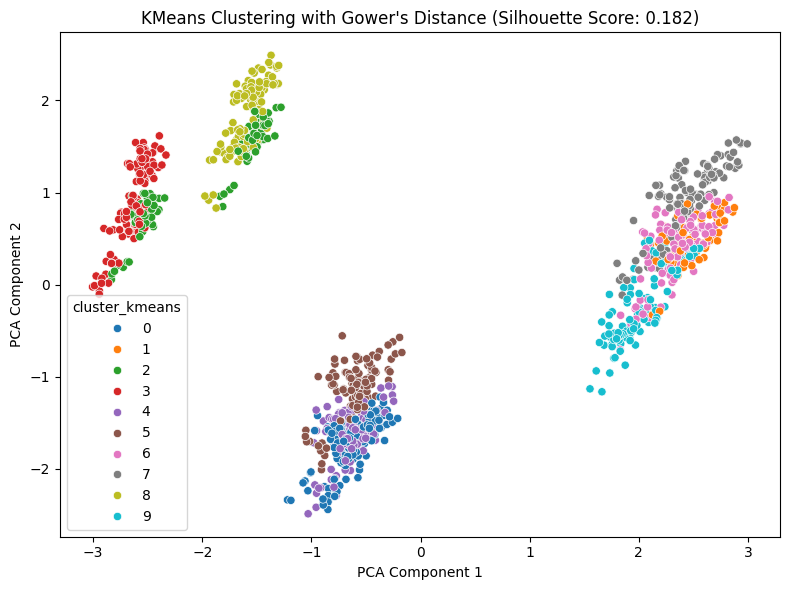

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
0    147
4    133
5    127
3    125
7    122
9    120
6    119
2    118
8    115
1     74
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 147
Cluster 1: 74
Cluster 2: 118
Cluster 3: 125
Cluster 4: 133
Cluster 5: 127
Cluster 6: 119
Cluster 7: 122
Cluster 8: 115
Cluster 9: 120


## k=30 kmeans

Silhouette Score: 0.182


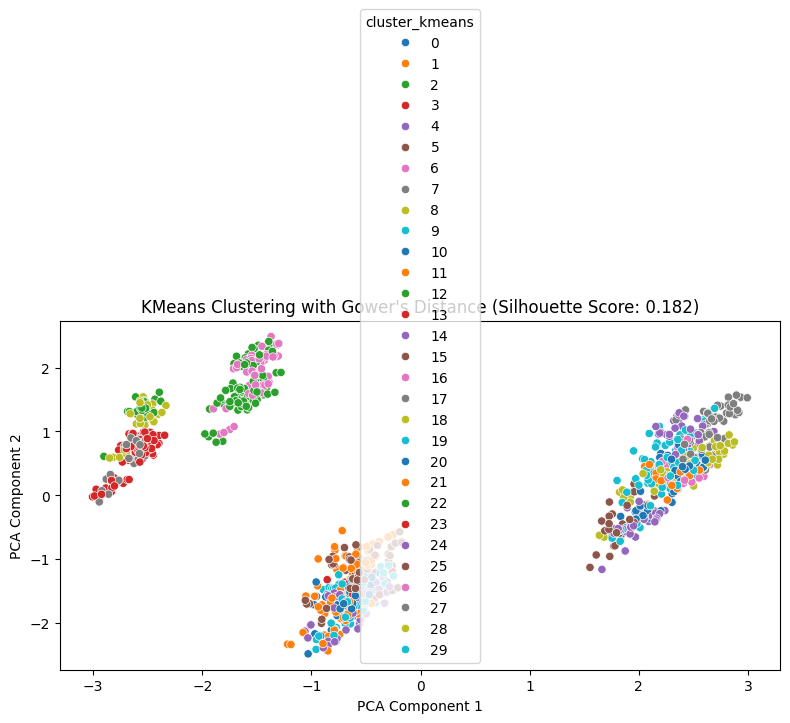

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
29    69
5     68
19    62
21    59
23    59
24    58
2     57
12    51
10    49
11    48
20    46
18    43
1     43
14    40
17    37
27    37
25    36
26    35
13    33
9     31
6     31
8     29
4     28
0     26
22    26
7     25
16    24
3     18
28    17
15    15
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 26
Cluster 1: 43
Cluster 2: 57
Cluster 3: 18
Cluster 4: 28
Cluster 5: 68
Cluster 6: 31
Cluster 7: 25
Cluster 8: 29
Cluster 9: 31
Cluster 10: 49
Cluster 11: 48
Cluster 12: 51
Cluster 13: 33
Cluster 14: 40
Cluster 15: 15
Cluster 16: 24
Cluster 17: 37
Cluster 18: 43
Cluster 19: 62
Cluster 20: 46
Cluster 21: 59
Cluster 22: 26
Cluster 23: 59
Cluster 24: 58
Cluster 25: 36
Cluster 26: 35
Cluster 27: 37
Cluster 28: 17
Cluster 29: 69


## k=50 kmeans

Silhouette Score: 0.182


<ipython-input-271-2112053073>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


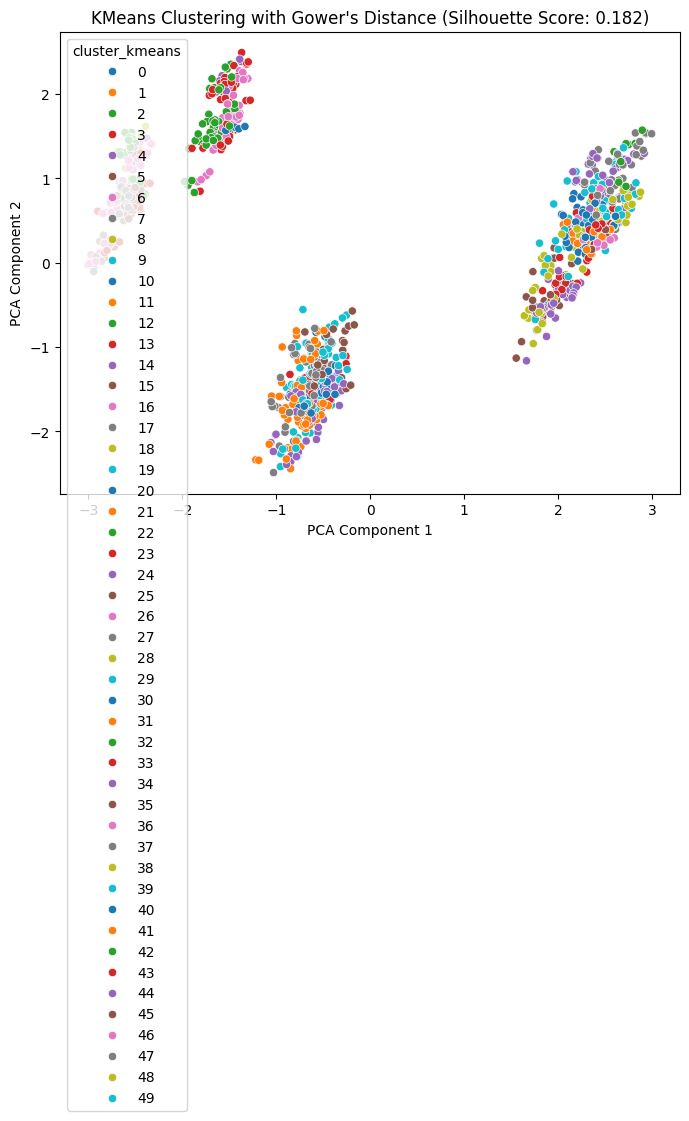

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_kmeans
24    58
11    56
29    53
47    44
17    37
23    37
33    36
30    34
37    33
14    30
12    30
36    30
45    29
49    29
2     28
4     28
43    28
19    27
6     26
31    25
21    25
5     24
27    24
25    23
0     22
38    21
22    21
7     20
16    19
48    19
39    18
28    18
20    18
1     18
3     18
46    18
26    17
9     17
41    16
10    14
42    13
35    13
34    13
40    12
15    11
44    11
18    11
8     10
32     9
13     9
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 22
Cluster 1: 18
Cluster 2: 28
Cluster 3: 18
Cluster 4: 28
Cluster 5: 24
Cluster 6: 26
Cluster 7: 20
Cluster 8: 10
Cluster 9: 17
Cluster 10: 14
Cluster 11: 56
Cluster 12: 30
Cluster 13: 9
Cluster 14: 30
Cluster 15: 11
Cluster 16: 19
Cluster 17: 37
Cluster 18: 11
Cluster 19: 27
Cluster 20: 18
Cluster 21: 25
Cluster 22: 21
Cluster 23: 37
Cluster 24: 58
Cluster 25: 23
Cluster 26: 17
Cluster 27: 24
Cluster 28: 18
Cluster 29: 53
Cluster 30: 34
Cluster 31: 25
Cluster 32: 9
Cluster 33: 36
Cluster 34: 13
Cluster 35: 13
Cluster 36: 30
Cluster 37: 33
Cluster 38: 21
Cluster 39: 18
Cluster 40: 12
Cluster 41: 16
Cluster 42: 13
Cluster 43: 28
Cluster 44: 11
Cluster 45: 29
Cluster 46: 18
Cluster 47: 44
Cluster 48: 19
Cluster 49: 29


## Grouping and comparing various types of k

In [ ]:
#k=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 6
Route: Belfort ➝ Nice
Start Dates: 2025-03-03 – 2025-03-03
Driver: Marguerite Carlier (ID: 1)
(No passengers – solo driver)

Group group_250 | Cluster: 0
Route: Belfort ➝ Dijon
Start Dates: 2023-10-18 – 2023-10-18
Driver: Christophe Carre (ID: 357)
(No passengers – solo driver)

Group group_251 | Cluster: 0
Route: Belfort ➝ Dijon
Start Dates: 2024-12-28 – 2024-12-28
Driver: Noël Thomas (ID: 823)
(No passengers – solo driver)

Group group_252 | Cluster: 0
Route: Belfort ➝ Dijon
Start Dates: 2025-03-03 – 2025-03-03
Driver: Benoît Renard (ID: 351)
(No passengers – solo driver)

Group group_253 | Cluster: 0
Route: Belfort ➝ Dijon
Start Dates: 2025-03-04 – 2025-03-04
Driver: Jeanne Rocher (ID: 305)
(No passengers – solo driver)

Group group_254 | Cluster: 0
Route: Belfort ➝ Lyon
Start Dates: 2020-10-10 – 2020-10-10
Driver: Margaud Meunier (ID: 847)
(No passengers – solo driver)

Gro

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 19
Route: Belfort ➝ Paris
Start Dates: 2021-04-16 – 2021-04-16
Driver: Claude De Oliveira (ID: 1070)
(No passengers – solo driver)

Group group_250 | Cluster: 21
Route: Montbéliard ➝ Lyon
Start Dates: 2021-04-16 – 2021-04-16
Driver: Thérèse Rémy (ID: 782)
(No passengers – solo driver)

Group group_251 | Cluster: 21
Route: Montbéliard ➝ Lyon
Start Dates: 2021-07-30 – 2021-07-30
Driver: Philippine Guillou (ID: 898)
(No passengers – solo driver)

Group group_252 | Cluster: 21
Route: Montbéliard ➝ Lyon
Start Dates: 2021-12-08 – 2021-12-08
Driver: Thierry Tessier (ID: 1106)
(No passengers – solo driver)

Group group_253 | Cluster: 21
Route: Montbéliard ➝ Lyon
Start Dates: 2022-05-22 – 2022-05-22
Driver: Célina Boyer (ID: 500)
(No passengers – solo driver)

Group group_254 | Cluster: 21
Route: Montbéliard ➝ Lyon
Start Dates: 2022-10-13 – 2022-10-13
Driver: Sébastien Peltier (ID: 972)
(

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 30
Route: Belfort ➝ Paris
Start Dates: 2021-08-24 – 2021-08-24
Driver: Luc Leclerc (ID: 850)
(No passengers – solo driver)

Group group_250 | Cluster: 47
Route: Montbéliard ➝ Toulouse
Start Dates: 2021-08-23 – 2021-08-23
Driver: Alphonse Baudry (ID: 363)
(No passengers – solo driver)

Group group_251 | Cluster: 47
Route: Montbéliard ➝ Toulouse
Start Dates: 2022-01-03 – 2022-01-03
Driver: Valérie Renaud (ID: 1174)
(No passengers – solo driver)

Group group_252 | Cluster: 47
Route: Montbéliard ➝ Toulouse
Start Dates: 2022-03-16 – 2022-03-16
Driver: Nathalie Bruneau (ID: 45)
(No passengers – solo driver)

Group group_253 | Cluster: 47
Route: Montbéliard ➝ Toulouse
Start Dates: 2023-09-01 – 2023-09-01
Driver: Margot Petit (ID: 1200)
(No passengers – solo driver)

Group group_254 | Cluster: 47
Route: Montbéliard ➝ Toulouse
Start Dates: 2024-09-04 – 2024-09-04
Driver: Jules Fournier (I

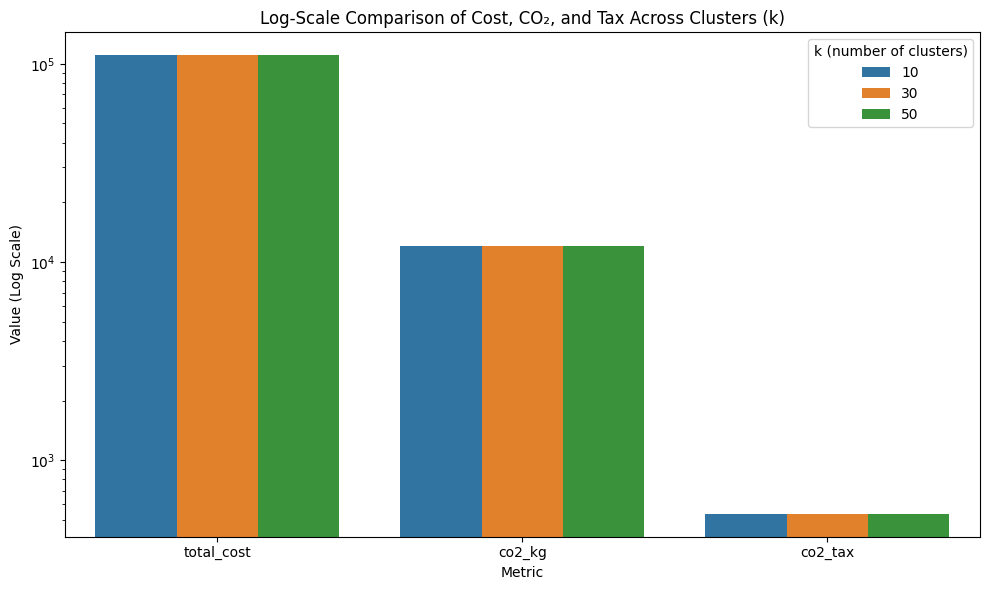

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [12051.48, 12051.48, 12051.48],
    "co2_tax": [537.5, 537.5, 537.5]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

## Optimization of algorithm based on results of k=10, 30 and 50 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

##Comparison of optimized results

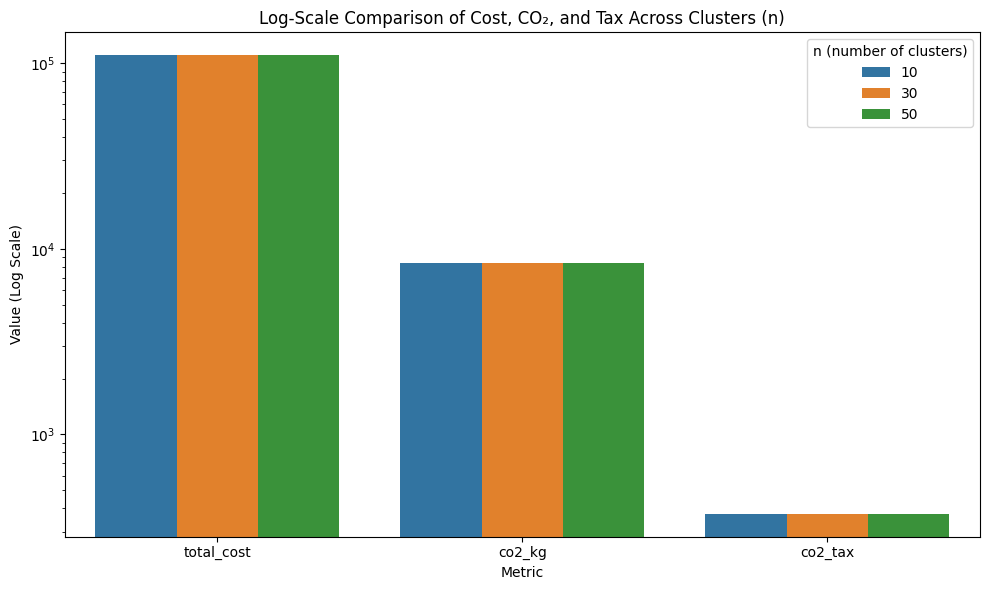

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [8398.82, 8398.82, 8398.82],
    "co2_tax": [374.59, 374.59, 374.59]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

## Agnes with n=10, 11 features

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.328


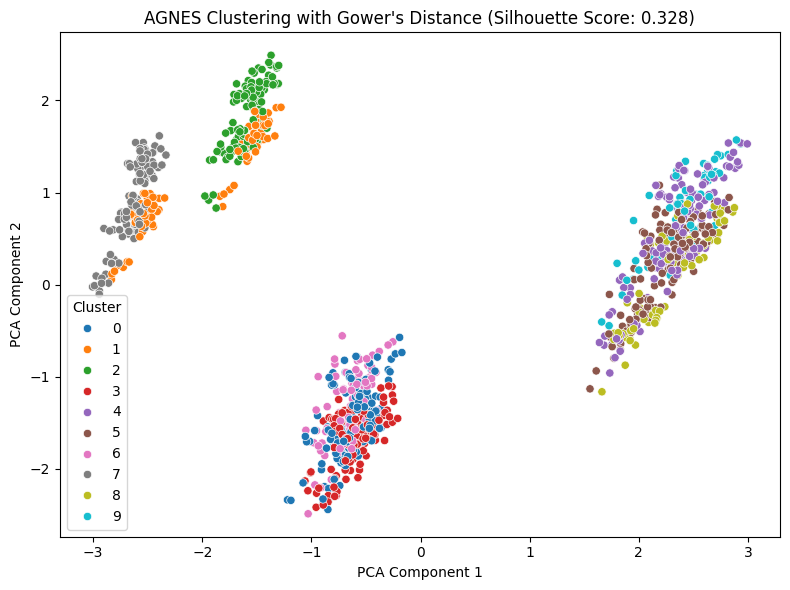

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
4    159
0    152
3    143
5    139
7    125
1    118
2    115
6    112
8     79
9     58
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 152
Cluster 1: 118
Cluster 2: 115
Cluster 3: 143
Cluster 4: 159
Cluster 5: 139
Cluster 6: 112
Cluster 7: 125
Cluster 8: 79
Cluster 9: 58


## Agnes with n=30, 11 features

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.346


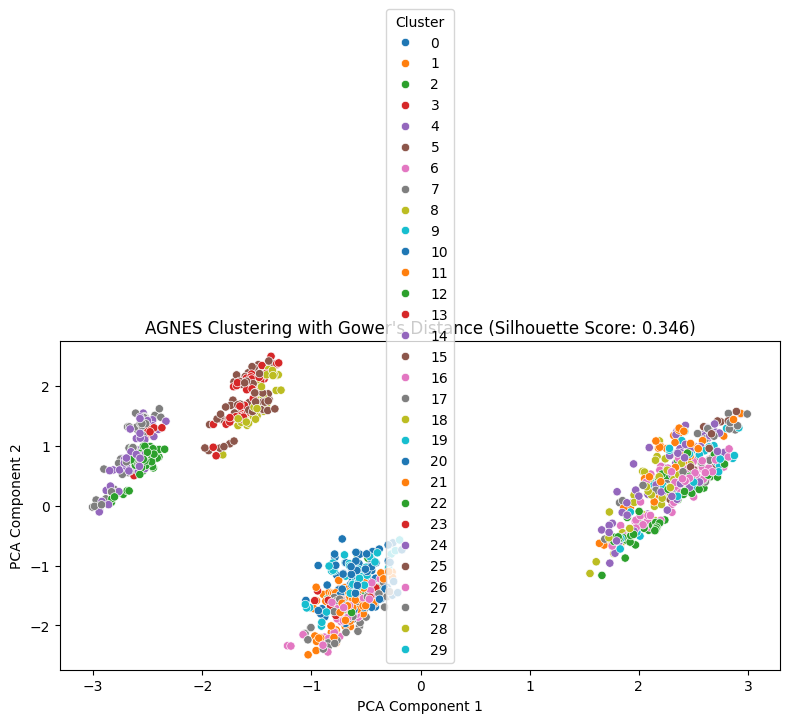

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
12    68
21    65
0     61
19    59
2     59
8     56
14    56
16    56
6     55
1     55
27    52
7     51
3     50
24    46
5     43
4     42
15    33
11    33
9     30
17    28
26    27
10    26
28    26
18    22
13    20
23    18
22    18
20    18
25    16
29    11
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 61
Cluster 1: 55
Cluster 2: 59
Cluster 3: 50
Cluster 4: 42
Cluster 5: 43
Cluster 6: 55
Cluster 7: 51
Cluster 8: 56
Cluster 9: 30
Cluster 10: 26
Cluster 11: 33
Cluster 12: 68
Cluster 13: 20
Cluster 14: 56
Cluster 15: 33
Cluster 16: 56
Cluster 17: 28
Cluster 18: 22
Cluster 19: 59
Cluster 20: 18
Cluster 21: 65
Cluster 22: 18
Cluster 23: 18
Cluster 24: 46
Cluster 25: 16
Cluster 26: 27
Cluster 27: 52
Cluster 28: 26
Cluster 29: 11


## Agnes with n=50 with 11 features

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.348


<ipython-input-291-2529285127>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


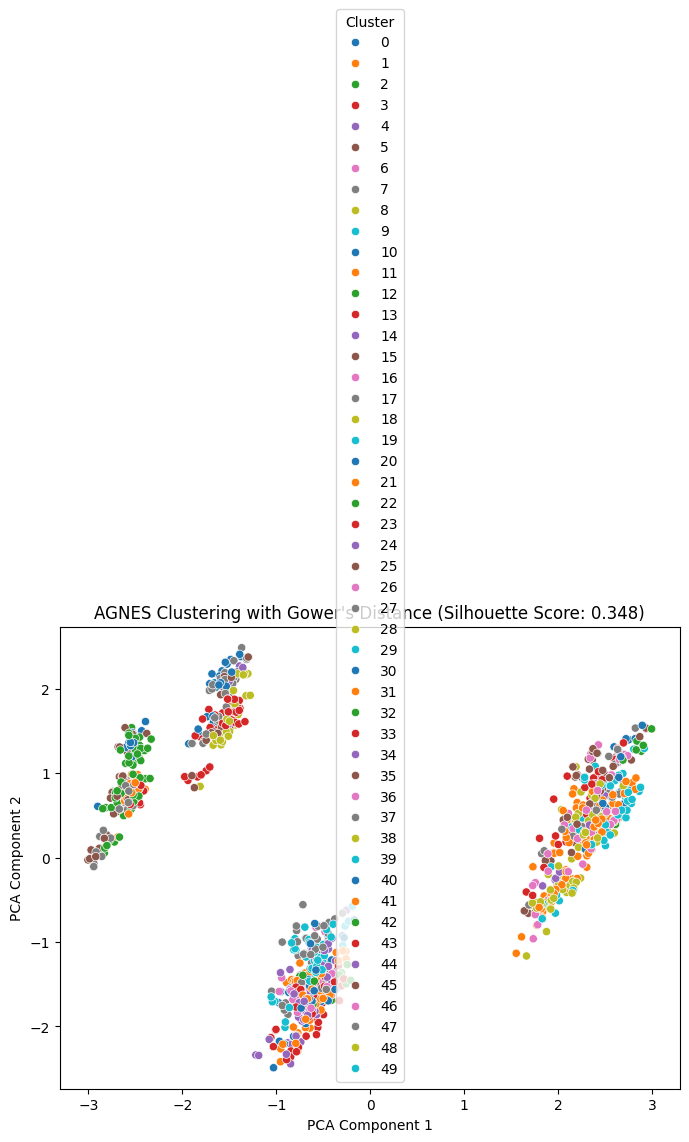

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=50, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_agnes
21    65
19    59
8     56
13    52
4     46
17    44
1     39
25    37
11    36
3     33
12    31
9     30
15    30
7     28
26    27
30    27
31    27
16    27
28    26
23    26
22    26
10    26
5     25
47    25
32    22
27    20
6     20
41    19
46    18
2     18
20    18
14    17
33    16
36    16
0     16
38    14
40    14
35    12
39    12
29    11
24    10
48    10
43    10
18    10
45    10
37     9
44     8
42     8
49     7
34     7
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 16
Cluster 1: 39
Cluster 2: 18
Cluster 3: 33
Cluster 4: 46
Cluster 5: 25
Cluster 6: 20
Cluster 7: 28
Cluster 8: 56
Cluster 9: 30
Cluster 10: 26
Cluster 11: 36
Cluster 12: 31
Cluster 13: 52
Cluster 14: 17
Cluster 15: 30
Cluster 16: 27
Cluster 17: 44
Cluster 18: 10
Cluster 19: 59
Cluster 20: 18
Cluster 21: 65
Cluster 22: 26
Cluster 23: 26
Cluster 24: 10
Cluster 25: 37
Cluster 26: 27
Cluster 27: 20
Cluster 28: 26
Cluster 29: 11
Cluster 30: 27
Cluster 31: 27
Cluster 32: 22
Cluster 33: 16
Cluster 34: 7
Cluster 35: 12
Cluster 36: 16
Cluster 37: 9
Cluster 38: 14
Cluster 39: 12
Cluster 40: 14
Cluster 41: 19
Cluster 42: 8
Cluster 43: 10
Cluster 44: 8
Cluster 45: 10
Cluster 46: 18
Cluster 47: 25
Cluster 48: 10
Cluster 49: 7


## Grouping and comparing agnes results

In [ ]:
#n=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 5
Route: Belfort ➝ Marseille
Start Dates: 2022-11-25 – 2022-11-25
Driver: Victor Texier (ID: 66)
(No passengers – solo driver)

Group group_250 | Cluster: 4
Route: Montbéliard ➝ Marseille
Start Dates: 2025-02-02 – 2025-02-02
Driver: Roland Brunet (ID: 1193)
(No passengers – solo driver)

Group group_251 | Cluster: 4
Route: Montbéliard ➝ Marseille
Start Dates: 2025-02-19 – 2025-02-19
Driver: Jean Barbier (ID: 683)
(No passengers – solo driver)

Group group_252 | Cluster: 4
Route: Montbéliard ➝ Marseille
Start Dates: 2025-03-09 – 2025-03-09
Driver: Aimé Gosselin (ID: 470)
(No passengers – solo driver)

Group group_253 | Cluster: 4
Route: Montbéliard ➝ Nice
Start Dates: 2020-12-16 – 2020-12-16
Driver: Josette Garnier (ID: 979)
(No passengers – solo driver)

Group group_254 | Cluster: 4
Route: Montbéliard ➝ Nice
Start Dates: 2021-02-02 – 2021-02-02
Driver: Patrick Baudry (ID: 569)
(N

In [ ]:
#n=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 8
Route: Belfort ➝ Marseille
Start Dates: 2022-11-25 – 2022-11-25
Driver: Victor Texier (ID: 66)
(No passengers – solo driver)

Group group_250 | Cluster: 0
Route: Montbéliard ➝ Marseille
Start Dates: 2022-12-23 – 2022-12-23
Driver: Honoré Lefort (ID: 735)
(No passengers – solo driver)

Group group_251 | Cluster: 0
Route: Montbéliard ➝ Marseille
Start Dates: 2023-02-14 – 2023-02-14
Driver: Nicolas Breton (ID: 1131)
(No passengers – solo driver)

Group group_252 | Cluster: 0
Route: Montbéliard ➝ Marseille
Start Dates: 2024-06-18 – 2024-06-18
Driver: Pénélope Garnier (ID: 36)
(No passengers – solo driver)

Group group_253 | Cluster: 0
Route: Montbéliard ➝ Marseille
Start Dates: 2024-09-04 – 2024-09-04
Driver: Adrienne Leclerc (ID: 10)
(No passengers – solo driver)

Group group_254 | Cluster: 0
Route: Montbéliard ➝ Marseille
Start Dates: 2024-09-17 – 2024-09-17
Driver: Julien Denis 

In [ ]:
#n=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_25 | Cluster: 5
Route: Montbéliard ➝ Lyon
Start Dates: 2021-04-27 – 2021-04-27
Driver: Théodore Colas (ID: 1158)
(No passengers – solo driver)

Group group_250 | Cluster: 19
Route: Montbéliard ➝ Dijon
Start Dates: 2021-09-25 – 2021-09-25
Driver: Sabine Camus (ID: 1094)
(No passengers – solo driver)

Group group_251 | Cluster: 19
Route: Montbéliard ➝ Dijon
Start Dates: 2021-12-08 – 2021-12-08
Driver: Manon Gay (ID: 647)
(No passengers – solo driver)

Group group_252 | Cluster: 19
Route: Montbéliard ➝ Dijon
Start Dates: 2021-12-19 – 2021-12-19
Driver: Luc Guichard (ID: 739)
(No passengers – solo driver)

Group group_253 | Cluster: 19
Route: Montbéliard ➝ Dijon
Start Dates: 2022-02-10 – 2022-02-10
Driver: Marthe Marques (ID: 938)
(No passengers – solo driver)

Group group_254 | Cluster: 19
Route: Montbéliard ➝ Dijon
Start Dates: 2022-02-11 – 2022-02-11
Driver: Luc Robin (ID: 635)
(No passengers –

## Optimization algorithm with n=10 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

## Optimization algorithm with n=30 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Amélie Chauveau assigned to solo train travel.
[Info] Andrée Baron assigned to solo train travel.
[Info] Pénélope Lefebvre assigned to solo train travel.
[Info] Paulette Chartier assigned to solo train travel.
[Info] Marine Dubois assigned to solo train travel.
[Info] Laetitia Maury assigned to solo train travel.
[Info] Valentine Antoine assigned to solo train travel.
[Info] Suzanne Vallet assigned to solo train travel.
[Info] Inès Morin assigned to solo train travel.
[Info] Sébastien Perrier assigned to solo train travel.
[Info] Chantal Voisin assigned to solo train travel.
[Info] Aurore Richard assigned to solo train travel.
[Info] Astrid Louis assigned to solo train travel.
[Info] Emmanuelle Marty assigned to solo train travel.
[Info] Alfred Andre assigned to solo train travel.
[Info] Danielle Léger assigned to solo train travel.
[Info] David Henry assigned to solo train travel.
[Info] Jean Turpin assigned to solo train travel.
[Info] Roger Blanc assigned to solo train travel

## Optimization of algorithm with n=50 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Claudine Bertin assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Mathilde Fontaine assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Édith Dupuy assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Élisabeth Germain assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to so

The comparison bar was not plotted in this case, since it is identical to the one for KMeans in the Experiment 2.

# Improvement (Experiment 3) - 5 features (start_city, end_city, start_date_ord, end_date_ord, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["start_date"])
df["start_date_ord"] = df["start_date"].apply(lambda x: x.toordinal()) #ordinal numeric format, in order to be able to apply the clustering algorithms
df["end_date_ord"] = df["end_date"].apply(lambda x: x.toordinal())
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
features = ["start_city", "end_city", "start_date_ord", "end_date_ord", "is_return_trip"]
df_selected = df[features].copy()

In [ ]:
categorical_cols = ["start_city", "end_city", "is_return_trip"]
numerical_cols = ["start_date_ord", "end_date_ord"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]),
                            columns=encoder.get_feature_names_out(categorical_cols))

scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)

## Kmeans

Best Silhouette Score: 0.341 at k=60


<ipython-input-304-3012277736>:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


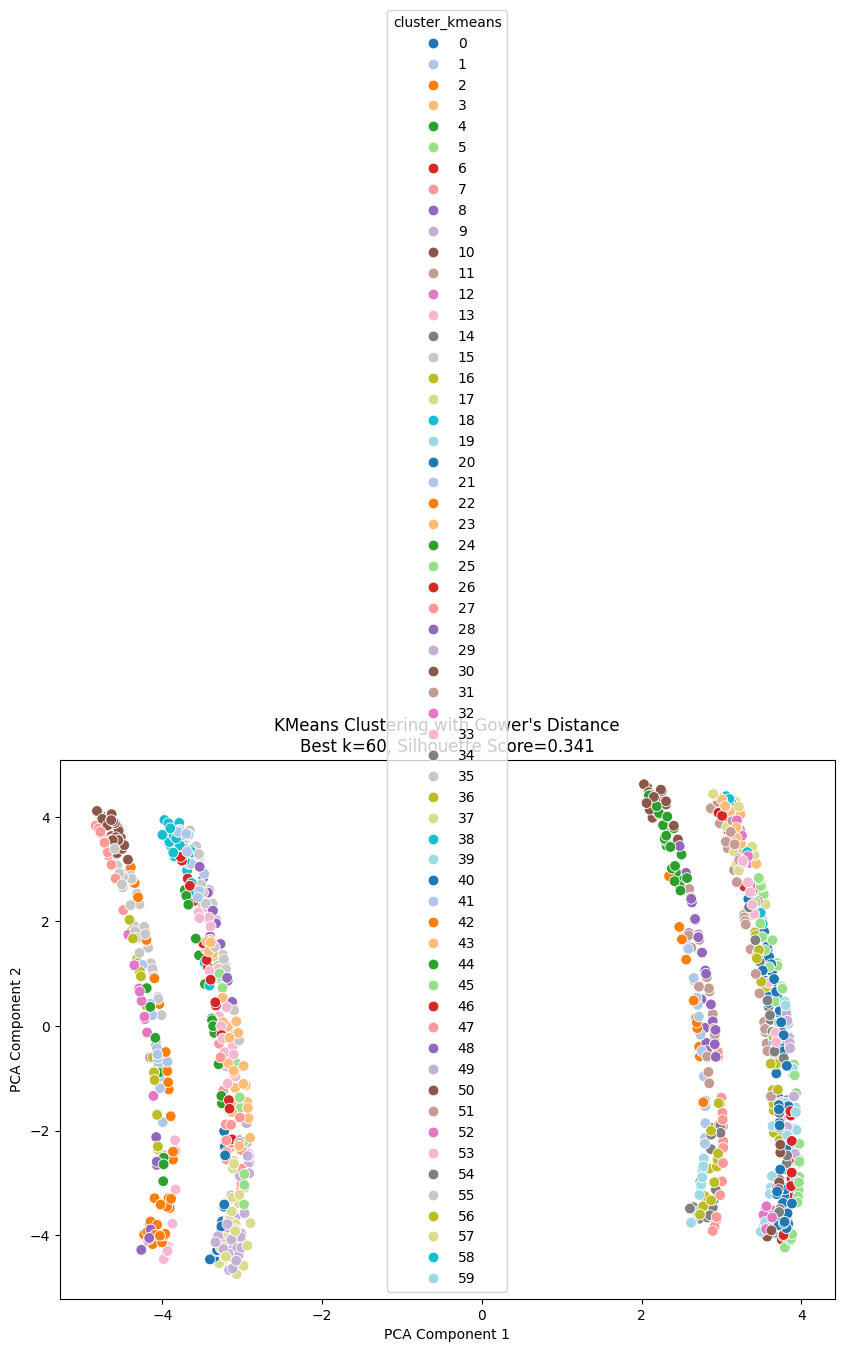

In [ ]:
gower_matrix = gower.gower_matrix(df_selected)

#grid search over k values
silhouette_scores = []
best_score = -1
best_k = None
best_labels = None

for k in range(10, 61, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gower_matrix)
    labels = kmeans.labels_

    try:
        score = silhouette_score(gower_matrix, labels)
        silhouette_scores.append((k, score))

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
    except:
        silhouette_scores.append((k, np.nan))

print(f"Best Silhouette Score: {best_score:.3f} at k={best_k}")

df["cluster_kmeans"] = best_labels

pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_kmeans"], palette="tab20", s=60)
plt.title(f"KMeans Clustering with Gower's Distance\nBest k={best_k}, Silhouette Score={best_score:.3f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 60
Cluster sizes:
 cluster_kmeans
9     42
0     37
58    34
20    33
24    33
30    33
55    32
17    32
42    31
43    29
45    28
41    28
28    26
16    25
53    25
11    24
10    24
49    23
23    22
31    22
5     22
39    21
27    21
47    20
33    19
29    19
22    19
51    19
40    19
12    18
21    18
36    18
56    18
26    18
14    18
1     17
54    17
19    17
32    16
37    16
38    16
4     15
25    15
35    15
57    14
48    14
46    14
34    14
7     13
50    12
44    12
2     12
13    12
59    11
8     11
6     10
18    10
52    10
3      9
15     8
Name: count, dtype: int64


In [ ]:
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv", cluster_col="cluster_kmeans")


Streaming output truncated to the last 5000 lines.
(No passengers – solo driver)

Group group_256 | Cluster: 23
Route: Montbéliard ➝ Lyon
Start Dates: 2024-07-18 – 2024-07-18
Driver: Guy Klein (ID: 1135)
(No passengers – solo driver)

Group group_257 | Cluster: 23
Route: Montbéliard ➝ Lyon
Start Dates: 2024-09-17 – 2024-09-17
Driver: Michelle Bodin (ID: 562)
(No passengers – solo driver)

Group group_258 | Cluster: 23
Route: Montbéliard ➝ Lyon
Start Dates: 2025-03-31 – 2025-03-31
Driver: Véronique Brunel (ID: 1125)
(No passengers – solo driver)

Group group_259 | Cluster: 23
Route: Montbéliard ➝ Lyon
Start Dates: 2025-05-28 – 2025-05-28
Driver: Théodore Marin (ID: 960)
(No passengers – solo driver)

Group group_26 | Cluster: 58
Route: Belfort ➝ Toulouse
Start Dates: 2025-06-12 – 2025-06-12
Driver: Danielle Jacques (ID: 927)
(No passengers – solo driver)

Group group_260 | Cluster: 23
Route: Montbéliard ➝ Nice
Start Dates: 2024-08-12 – 2024-08-12
Driver: Henriette Martin (ID: 747)
(No p

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to solo train travel.
[Info] Émilie Paris assigned to solo train travel.
[Info] Bertrand Millet assigned to solo train travel.
[Info] Odette Barthelemy assigned to solo train travel.
[Info] Emmanuel Delattre assigned to s

## AGNES

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  

Best Silhouette Score: 0.648 at k=60, linkage=average


<ipython-input-309-867904592>:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


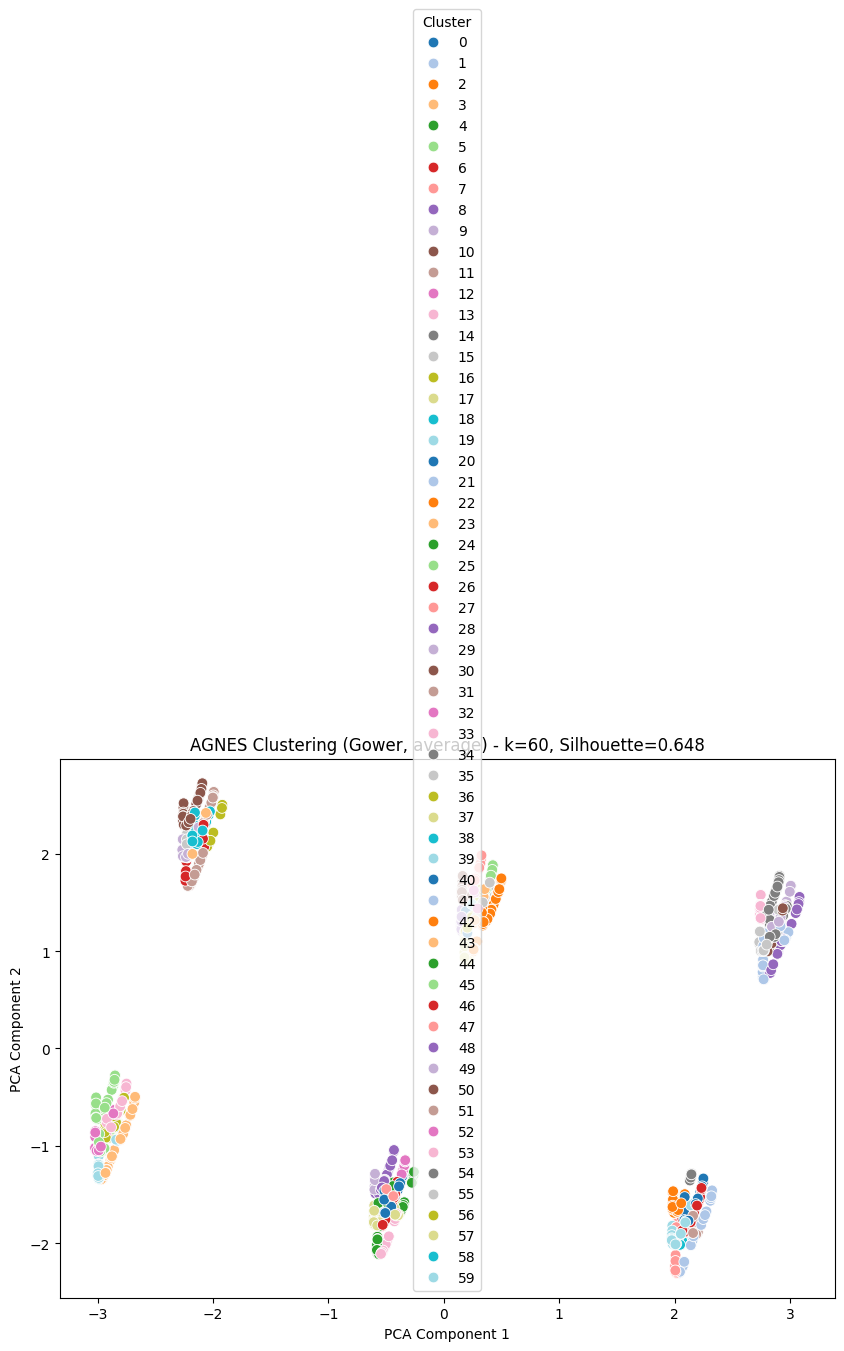

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

best_score = -1
best_k = None
best_linkage = None
best_labels = None
silhouette_scores = []

linkage_methods = ["average", "complete"]

for linkage in linkage_methods:

    for k in range(10, 61, 10):
        try:
            agnes = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage=linkage)
            labels = agnes.fit_predict(gower_matrix)
            score = silhouette_score(gower_matrix, labels, metric='cosine')
            silhouette_scores.append((k, linkage, score))

            if score > best_score:
                best_score = score
                best_k = k
                best_linkage = linkage
                best_labels = labels
        except Exception as e:
            silhouette_scores.append((k, linkage, np.nan))
            continue

print(f"Best Silhouette Score: {best_score:.3f} at k={best_k}, linkage={best_linkage}")

df["cluster_agnes"] = best_labels

pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab20", s=60)
plt.title(f"AGNES Clustering (Gower, {best_linkage}) - k={best_k}, Silhouette={best_score:.3f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 60
Cluster sizes:
 cluster_agnes
5     36
9     36
3     35
0     33
12    32
39    32
20    31
13    30
10    29
14    29
30    28
15    27
25    27
6     27
7     27
19    26
28    26
4     25
46    25
29    25
1     24
18    24
16    24
2     23
22    23
34    22
41    22
21    21
37    21
8     21
11    19
35    18
38    18
50    18
31    17
33    17
57    17
32    17
17    16
52    16
36    16
53    15
44    13
27    13
42    13
47    12
55    12
58    12
51    12
48    11
40    11
49    10
26    10
24    10
43     9
56     8
23     8
45     8
59     7
54     6
Name: count, dtype: int64


In [ ]:
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv", cluster_col="cluster_agnes")


Streaming output truncated to the last 5000 lines.
Driver: Michèle Letellier (ID: 1051)
(No passengers – solo driver)

Group group_256 | Cluster: 31
Route: Montbéliard ➝ Lyon
Start Dates: 2024-07-19 – 2024-07-19
Driver: Claire Bertin (ID: 343)
(No passengers – solo driver)

Group group_257 | Cluster: 31
Route: Montbéliard ➝ Lyon
Start Dates: 2024-10-20 – 2024-10-20
Driver: Honoré Georges (ID: 464)
(No passengers – solo driver)

Group group_258 | Cluster: 31
Route: Montbéliard ➝ Lyon
Start Dates: 2024-12-25 – 2024-12-25
Driver: David Da Silva (ID: 17)
(No passengers – solo driver)

Group group_259 | Cluster: 31
Route: Montbéliard ➝ Lyon
Start Dates: 2025-01-22 – 2025-01-22
Driver: Inès Alexandre (ID: 1124)
(No passengers – solo driver)

Group group_26 | Cluster: 13
Route: Montbéliard ➝ Lyon
Start Dates: 2023-05-10 – 2023-05-10
Driver: Richard Coulon (ID: 342)
(No passengers – solo driver)

Group group_260 | Cluster: 31
Route: Montbéliard ➝ Lyon
Start Dates: 2025-02-02 – 2025-02-02
Drive

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Nathalie Lévy assigned to solo train travel.
[Info] Nathalie De Sousa assigned to solo train travel.
[Info] Thibaut Chauvin assigned to solo train travel.
[Info] Adrienne Charles assigned to solo train travel.
[Info] Agnès Martin assigned to solo train travel.
[Info] Denise Camus assigned to solo train travel.
[Info] Henriette Lemonnier assigned to solo train travel.
[Info] Margot Navarro assigned to solo train travel.
[Info] Denise Brun assigned to solo train travel.
[Info] Aurore Techer assigned to solo train travel.
[Info] Véronique Poirier assigned to solo train travel.
[Info] Édouard Duval assigned to solo train travel.
[Info] Manon Hervé assigned to solo train travel.
[Info] Suzanne Delannoy assigned to solo train travel.
[Info] Marcelle Fontaine assigned to solo train travel.
[Info] Émilie Paris assigned to solo train travel.
[Info] Bertrand Millet assigned to solo train travel.
[Info] Odette Barthelemy assigned to solo train travel.
[Info] Emmanuel Delattre assigned to s